<a href="https://colab.research.google.com/github/naddine/attic_task/blob/main/notebooks/analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Customer Purchase Behavior Analysis**

# **Data Overview and Preprocessing**

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# plot style
plt.style.use('default')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

print("All libraries loaded successfully.")


# LOADING THE DATASET
# =======================================
file_name = "shopping_trends.csv"  # 👈 CHANGE THIS TO YOUR FILE NAME
df = pd.read_csv(file_name)

print(f"Dataset shape: {df.shape} (rows, columns)")

print("\nFirst 5 rows of data:")
print(df.head())

print("\nFeatures:")
print(df.info())

# Check for missing values
missing_values = df.isnull().sum()
print(f"Missing Values: {missing_values.sum()}")

# Check for duplicates
duplicates = df.duplicated().sum()
print(f"\nDuplicate rows: {duplicates}")

# Basic statistics
print("\nKey Statistics:")
print(df.describe())

# =======================================

## Upon preliminary analysis in Excel, I noticed redundant terms in frequency categories, so I standardized them first before further analysis.
# Check what frequency categories we have
# print(df['Frequency of Purchases'].value_counts())

# Standardize the frequency categories
frequency_mapping = {
    'Every 3 Months': 'Quarterly',  # Standardize to Quarterly
    'Fortnightly': 'Bi-Weekly',     # Standardize to Bi-Weekly
    'Weekly': 'Weekly',
    'Monthly': 'Monthly',
    'Annually': 'Annually',
    'Quarterly': 'Quarterly',
    'Bi-Weekly': 'Bi-Weekly'
}

df['Frequency of Purchases'] = df['Frequency of Purchases'].map(frequency_mapping)

# Check
# print(df['Frequency of Purchases'].value_counts())

# =======================================

## The location values are too granular, mapping them into regions might help with patterns and analysis.
region_map = {
    # Northeast
    **dict.fromkeys(['Connecticut', 'Maine', 'Massachusetts', 'New Hampshire',
                     'New Jersey', 'New York', 'Pennsylvania', 'Rhode Island', 'Vermont'], 'Northeast'),
    # Midwest
    **dict.fromkeys(['Illinois', 'Indiana', 'Iowa', 'Kansas', 'Michigan', 'Minnesota',
                     'Missouri', 'Nebraska', 'North Dakota', 'Ohio', 'South Dakota', 'Wisconsin'], 'Midwest'),
    # South
    **dict.fromkeys(['Alabama', 'Arkansas', 'Delaware', 'District of Columbia', 'Florida',
                     'Georgia', 'Kentucky', 'Louisiana', 'Maryland', 'Mississippi', 'North Carolina',
                     'Oklahoma', 'South Carolina', 'Tennessee', 'Texas', 'Virginia', 'West Virginia'], 'South'),
    # West
    **dict.fromkeys(['Alaska', 'Arizona', 'California', 'Colorado', 'Hawaii', 'Idaho',
                     'Montana', 'Nevada', 'New Mexico', 'Oregon', 'Utah', 'Washington', 'Wyoming'], 'West')
}
df['Region'] = df['Location'].map(region_map)

#check
# print(df['Region'].value_counts())

## Since this is marketing focused, it might be more helpful to group customers according to "generation".

def categorize_generation(age):
    if age <= 22:
        return "Gen Z"
    elif age <= 38:
        return "Millennial"
    elif age <= 54:
        return "Gen X"
    else:
        return "Boomer"

df['Generation'] = df['Age'].apply(categorize_generation)

# =======================================

## For analyses that are sensitive to categoricals, I encoded key features into numeric.

df['Subscription Status_num'] = df['Subscription Status'].map({'Yes': 1, 'No': 0})
df['Discount Applied_num'] = df['Discount Applied'].map({'Yes': 1, 'No': 0})
df['Season_num'] = df['Season'].map({'Winter': 0, 'Spring': 1, 'Summer': 2, 'Fall': 3})
  # Since we do not have temporal information available, we can only use seasonality for mapping trends. It is as ordered as it would be in the US.
df['Region_num'] = df['Region'].map({'South': 0, 'West': 1, 'Midwest': 2, 'Northeast': 3})
df['Gender_num'] = df['Gender'].map({'Female': 1, 'Male': 0})
df['Frequency_num'] = df['Frequency of Purchases'].map({
    'Weekly': 52,
    'Monthly': 12,
    'Annually': 1,
    'Quarterly': 4,
    'Bi-Weekly': 24 #twice a month
    })
  # I encoded the frequency categories into their annual "counterpart".
df['Category_num'] = df['Category'].map({'Clothing': 0, 'Footwear': 1, 'Accessories': 2, 'Outerwear': 3})
df['Generation_num']= df['Generation'].map({'Gen Z': 0, 'Millennial': 1, 'Gen X': 2, 'Boomer': 3})
# =======================================

## Rechecking other categoricals
categorical_columns = ['Gender', 'Category', 'Size', 'Color', 'Season',
                      'Subscription Status','Preferred Payment Method', 'Payment Method', 'Shipping Type']

table_data = []

for col in categorical_columns:
    unique_values = df[col].unique()
    if len(unique_values) <= 15:
        values_display = sorted(unique_values)
    else:
        values_display = f"{len(unique_values)} unique values"

    table_data.append({
        'Features': col,
        'Values': values_display
    })

features_table = pd.DataFrame(table_data)
display(features_table)

# =======================================

## Hypothesis: 'Promo Code Used' and 'Discount Applied' catches the same information.
(df['Discount Applied'] == df['Promo Code Used']).all()
# 100% identical. One feature may be dropped:
df = df.drop(columns=['Promo Code Used'])

# =======================================

# Check 'Payment Method' vs 'Preferred Payment Method' for consistency
# print("Payment Method values:", sorted(df['Payment Method'].unique()))
# print("Preferred Payment Method values:", sorted(df['Preferred Payment Method'].unique()))
## no errors

# =======================================

print(f"Final dataset shape: {df.shape}\n")
print("="*80)
print("\nFirst 5 rows of CLEANED data:\n")
print(df.head())

All libraries loaded successfully.
Dataset shape: (3900, 19) (rows, columns)

First 5 rows of data:
   Customer ID  Age Gender Item Purchased  Category  Purchase Amount (USD)  \
0            1   55   Male         Blouse  Clothing                     53   
1            2   19   Male        Sweater  Clothing                     64   
2            3   50   Male          Jeans  Clothing                     73   
3            4   21   Male        Sandals  Footwear                     90   
4            5   45   Male         Blouse  Clothing                     49   

        Location Size      Color  Season  Review Rating Subscription Status  \
0       Kentucky    L       Gray  Winter            3.1                 Yes   
1          Maine    L     Maroon  Winter            3.1                 Yes   
2  Massachusetts    S     Maroon  Spring            3.1                 Yes   
3   Rhode Island    M     Maroon  Spring            3.5                 Yes   
4         Oregon    M  Turquoise  Sp

,Features,Values
0,Gender,"[Female, Male]"
1,Category,"[Accessories, Clothing, Footwear, Outerwear]"
2,Size,"[L, M, S, XL]"
3,Color,25 unique values
4,Season,"[Fall, Spring, Summer, Winter]"
5,Subscription Status,"[No, Yes]"
6,Preferred Payment Method,"[Bank Transfer, Cash, Credit Card, Debit Card,..."
7,Payment Method,"[Bank Transfer, Cash, Credit Card, Debit Card,..."
8,Shipping Type,"[2-Day Shipping, Express, Free Shipping, Next ..."


Final dataset shape: (3900, 28)


First 5 rows of CLEANED data:

   Customer ID  Age Gender Item Purchased  Category  Purchase Amount (USD)  \
0            1   55   Male         Blouse  Clothing                     53   
1            2   19   Male        Sweater  Clothing                     64   
2            3   50   Male          Jeans  Clothing                     73   
3            4   21   Male        Sandals  Footwear                     90   
4            5   45   Male         Blouse  Clothing                     49   

        Location Size      Color  Season  ...     Region Generation  \
0       Kentucky    L       Gray  Winter  ...      South     Boomer   
1          Maine    L     Maroon  Winter  ...  Northeast      Gen Z   
2  Massachusetts    S     Maroon  Spring  ...  Northeast      Gen X   
3   Rhode Island    M     Maroon  Spring  ...  Northeast      Gen Z   
4         Oregon    M  Turquoise  Spring  ...       West      Gen X   

  Subscription Status_num Discount Appl

# **Data Exploration**

### **Q1: Do customers from particular areas spend more?**

Regional Analysis Overview:

           Total Revenue  Subscription Rate  Avg Spending  Total Customers
Region                                                                    
South              75275              28.40         59.23             1271
West               62289              27.31         61.19             1018
Midwest            55584              25.72         59.32              937
Northeast          39933              25.67         59.25              674


<Figure size 1200x600 with 0 Axes>

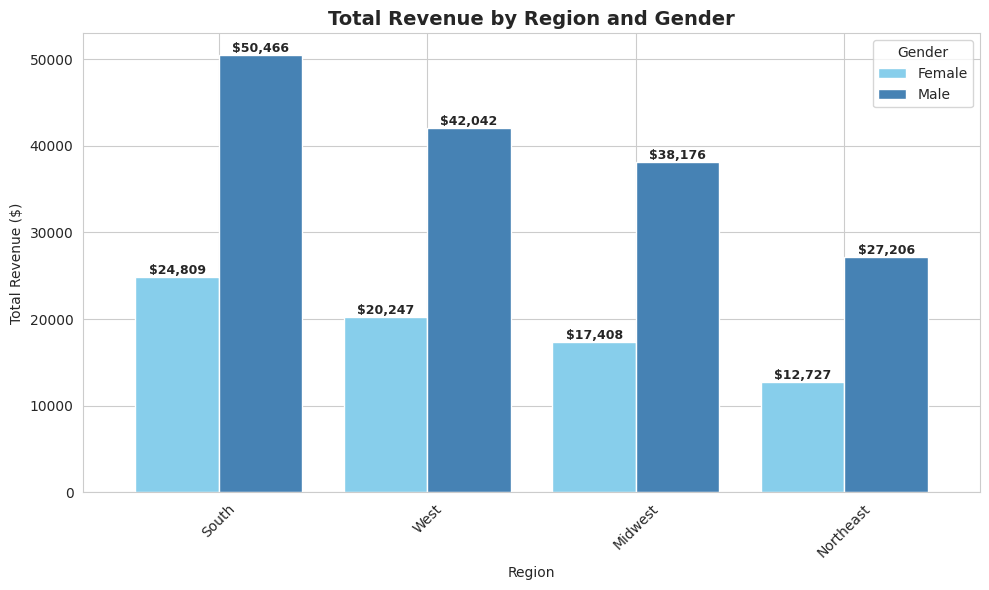

Total Revenue by Region and Gender ($):


Gender,Female,Male
Region,,
South,24809,50466
West,20247,42042
Midwest,17408,38176
Northeast,12727,27206


In [77]:
# QUESTION 1: Regional Market Analysis - Do customers from particular areas spend more?

# Recap: Location data have been aggregated into US Regions for better analysis. Exploration on Excel shows no interesting patterns or findings with raw "Location" data.

regional_analysis = df.groupby('Region').agg({
    'Purchase Amount (USD)': ['mean', 'count', 'sum'],
    'Subscription Status': lambda x: (x == 'Yes').mean() * 100,
    'Customer ID': 'nunique'
}).round(2)

regional_analysis.columns = ['Avg Spending', 'Transaction Count', 'Total Revenue', 'Subscription Rate', 'Total Customers']
regional_analysis = regional_analysis.sort_values('Total Revenue', ascending=False)

print("Regional Analysis Overview:\n")
print(regional_analysis[['Total Revenue', 'Subscription Rate', 'Avg Spending', 'Total Customers']].round(2))

# =========================================
# CHART 0 - Direct Answer

# Show total revenue by region and gender using grouped bar chart
regional_gender_revenue = df.groupby(['Region', 'Gender'])['Purchase Amount (USD)'].sum().unstack(fill_value=0)

# Sort by total revenue (sum of male + female)
regional_gender_revenue['Total'] = regional_gender_revenue.sum(axis=1)
regional_gender_revenue = regional_gender_revenue.sort_values('Total', ascending=False).drop('Total', axis=1)

plt.figure(figsize=(12, 6))
ax = regional_gender_revenue.plot(kind='bar', width=0.8, color=['skyblue', 'steelblue'])
plt.title('Total Revenue by Region and Gender', fontsize=14, fontweight='bold')
plt.xlabel('Region')
plt.ylabel('Total Revenue ($)')
plt.legend(title='Gender')
plt.xticks(rotation=45)

# Add value labels on top of bars
for container in ax.containers:
    ax.bar_label(container, fmt='${:,.0f}', fontsize=9, fontweight='bold')
plt.tight_layout()
plt.show()

# Show the data table
print("Total Revenue by Region and Gender ($):")
display(regional_gender_revenue)


Customers from the South drive the highest total revenue with a total of ~$75k. This is followed by the West USA, Midwest USA, then Northeast USA.

Exploring further the regionality of the customer base, we uncover that:

1. S**outh USA has the highest total number of customers**, with 1,271, unique customers, and the highest subscription rate among the four identified regions with 28.4% subscribed.
2. Despite being the largest contributor to revenue, customers from the South have a lower-than-average customer value (ACV) with \$59. **West USA customers has the highest ACV with \$61**, a dollar above the average.
3. Across the regions, all item categories perform consistently in terms of customer preference. The **most purchased item is Clothing**, and the least purchased is **Outerwear**.
4. The customer base is composed mainly of "Boomers", aged 55 to 70, at ~30%. This is true for all regions except the West, where majority is "Millennials". "GenZers" make up only about 9% of the entire customer base.


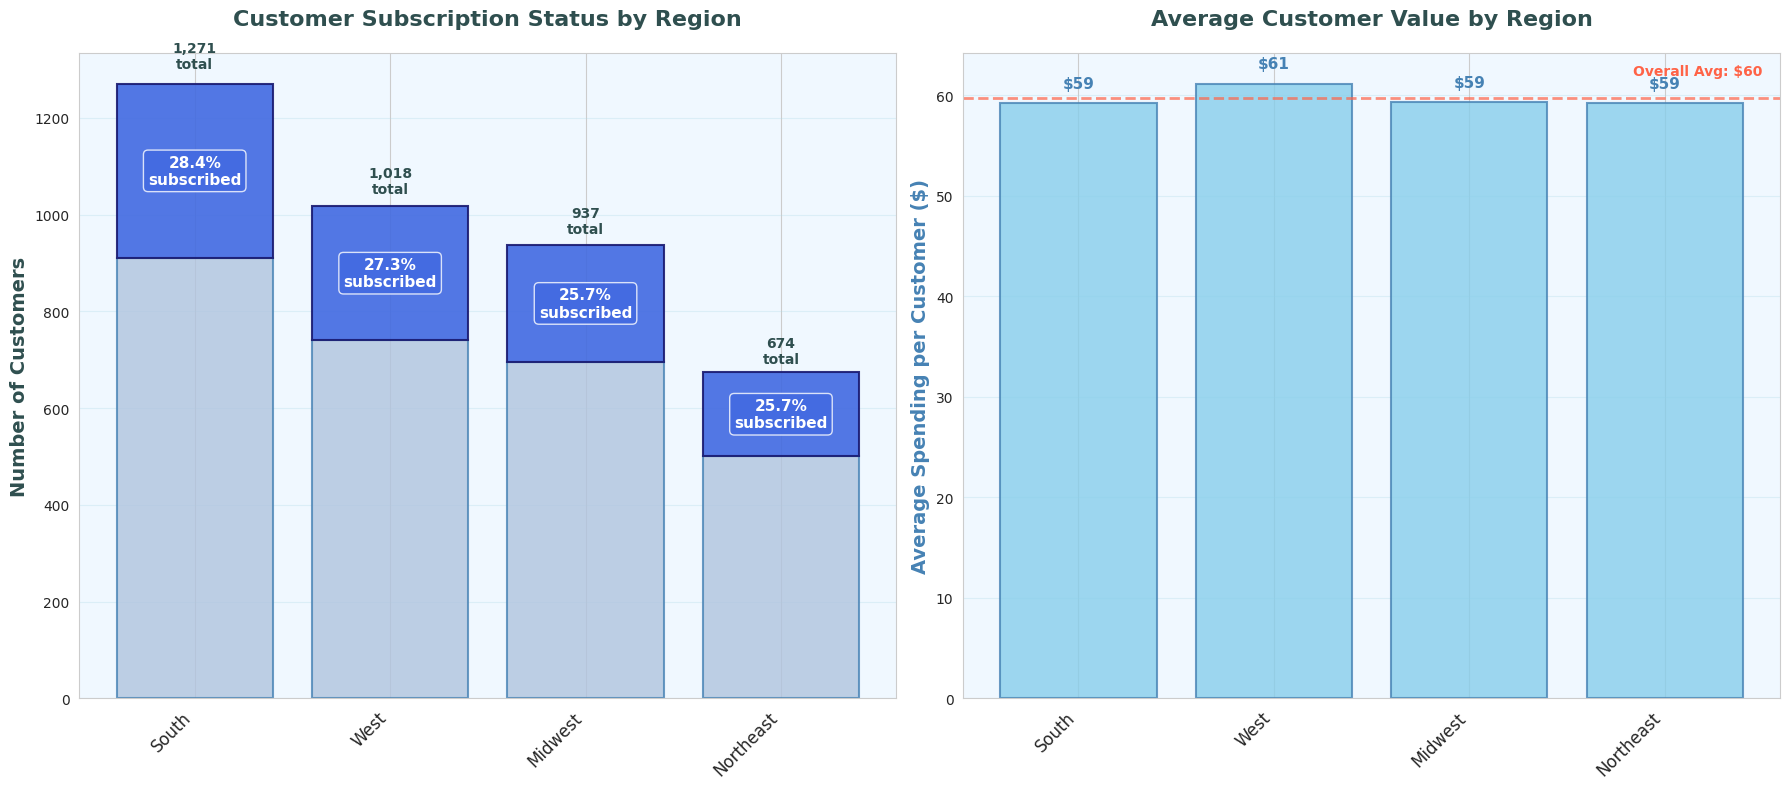

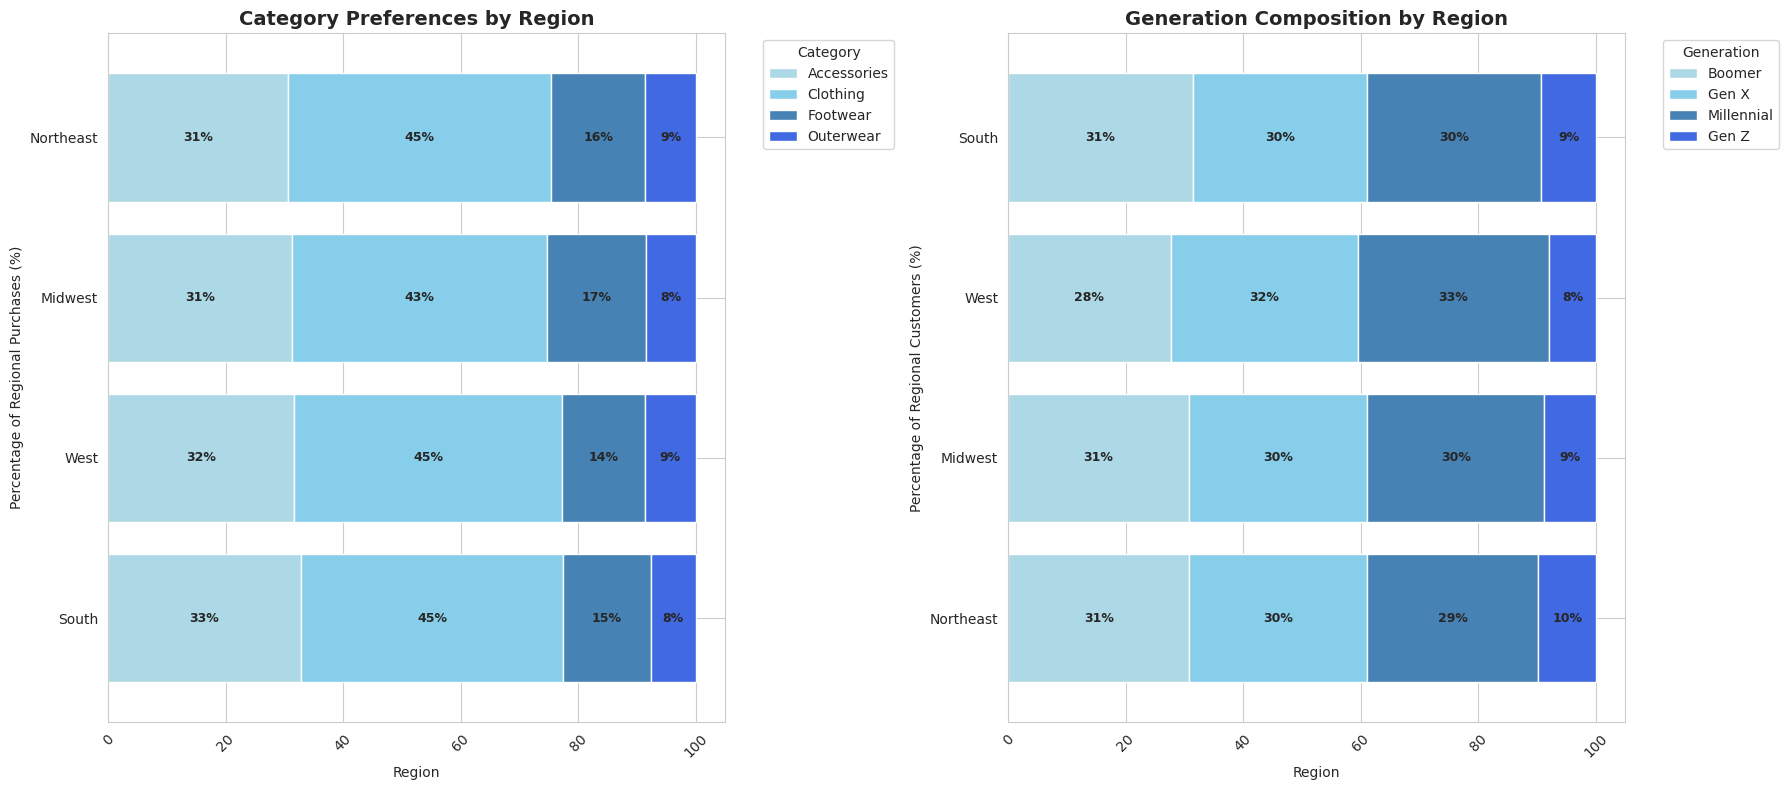

Category Preferences by Region (%):


Category,Accessories,Clothing,Footwear,Outerwear
Region,,,,
South,32.8,44.6,14.9,7.7
West,31.7,45.5,14.0,8.7
Midwest,31.4,43.2,17.0,8.4
Northeast,30.6,44.8,16.0,8.6



Generation Composition by Region (%):


Generation,Boomer,Gen X,Millennial,Gen Z
Region,,,,
Northeast,30.9,30.3,29.1,9.8
Midwest,30.7,30.3,30.2,8.8
West,27.7,31.8,32.5,8.0
South,31.5,29.6,29.7,9.3


In [78]:
# FOR 1,2
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Calculate subscriber counts for stacked bar
regional_analysis['Subscribers'] = (regional_analysis['Total Customers'] * regional_analysis['Subscription Rate'] / 100).round(0)
regional_analysis['Non Subscribers'] = regional_analysis['Total Customers'] - regional_analysis['Subscribers']

# CHART 1: Stacked Bar - Subscribers vs Non-Subscribers by Region

bars1_bottom = ax1.bar(range(len(regional_analysis)), regional_analysis['Non Subscribers'],
                       color='#B0C4DE', alpha=0.8, edgecolor='#4682B4', linewidth=1.5,
                       label='Non-Subscribers')

bars1_top = ax1.bar(range(len(regional_analysis)), regional_analysis['Subscribers'],
                    bottom=regional_analysis['Non Subscribers'],
                    color='#4169E1', alpha=0.9, edgecolor='#191970', linewidth=1.5,
                    label='Subscribers')

# Formatting for Chart 1
ax1.set_xticks(range(len(regional_analysis)))
ax1.set_xticklabels(regional_analysis.index, rotation=45, ha='right', fontsize=12)
ax1.set_ylabel('Number of Customers', color='#2F4F4F', fontweight='bold', fontsize=14)
ax1.set_title('Customer Subscription Status by Region',
              fontsize=16, fontweight='bold', pad=20, color='#2F4F4F')

# Add percentage labels on the bars
for i, region in enumerate(regional_analysis.index):
    total_customers = regional_analysis.loc[region, 'Total Customers']
    subscribers = regional_analysis.loc[region, 'Subscribers']
    sub_rate = regional_analysis.loc[region, 'Subscription Rate']

    ax1.text(i, total_customers + total_customers*0.02,
             f'{total_customers:,.0f}\ntotal', ha='center', va='bottom',
             fontsize=10, fontweight='bold', color='#2F4F4F')

    if subscribers > 0:  # Only show if there are subscribers
        subscribers_center = regional_analysis.loc[region, 'Non Subscribers'] + (subscribers / 2)
        ax1.text(i, subscribers_center, f'{sub_rate:.1f}%\nsubscribed',
                 ha='center', va='center', fontsize=11, fontweight='bold',
                 color='white', bbox=dict(boxstyle='round,pad=0.3', facecolor='#4169E1', alpha=0.8))

# =====================================

# CHART 2: Average Spending per Customer by Region

bars2 = ax2.bar(range(len(regional_analysis)), regional_analysis['Avg Spending'],
                color='#87CEEB', alpha=0.8, edgecolor='#4682B4', linewidth=1.5)

# Formatting for Chart 2
ax2.set_xticks(range(len(regional_analysis)))
ax2.set_xticklabels(regional_analysis.index, rotation=45, ha='right', fontsize=12)
ax2.set_ylabel('Average Spending per Customer ($)', color='#4682B4', fontweight='bold', fontsize=14)
ax2.set_title('Average Customer Value by Region',
              fontsize=16, fontweight='bold', pad=20, color='#2F4F4F')

# Add value labels on bars
for i, bar in enumerate(bars2):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, height + height*0.02,
             f'${height:.0f}', ha='center', va='bottom',
             fontsize=11, color='#4682B4', fontweight='bold')

# Add a subtle target line showing the overall average
overall_avg_spending = regional_analysis['Avg Spending'].mean()
ax2.axhline(y=overall_avg_spending, color='#FF6347', linestyle='--', linewidth=2, alpha=0.7)
ax2.text(len(regional_analysis)-0.5, overall_avg_spending + 2,
         f'Overall Avg: ${overall_avg_spending:.0f}',
         ha='right', va='bottom', fontsize=10, color='#FF6347', fontweight='bold')

# Add subtle grid for better readability
ax1.grid(axis='y', alpha=0.3, color='lightblue')
ax2.grid(axis='y', alpha=0.3, color='lightblue')

# Set background color to very light blue
ax1.set_facecolor('#F0F8FF')
ax2.set_facecolor('#F0F8FF')

plt.tight_layout()
plt.show()

# =====================================

# FOR 3,4
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# CHART 3: Category Preferences by Region
region_category_pct = pd.crosstab(df['Region'], df['Category'], normalize='index') * 100
# Sort by total revenue (largest to smallest regions)
region_order = df.groupby('Region')['Purchase Amount (USD)'].sum().sort_values(ascending=False).index
region_category_pct = region_category_pct.reindex(region_order)

region_category_pct.plot(kind='barh', stacked=True, width=0.8, ax=ax1, color=['lightblue', 'skyblue', 'steelblue', '#4169E1'])
ax1.set_title('Category Preferences by Region', fontsize=14, fontweight='bold')
ax1.set_xlabel('Region')
ax1.set_ylabel('Percentage of Regional Purchases (%)')
ax1.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.tick_params(axis='x', rotation=45)

# CHART 4: Generation Composition by Region
# Create generation groups -> move to preliminaries
# Generation composition by region
region_generation_pct = pd.crosstab(df['Region'], df['Generation'], normalize='index') * 100
# Sort by total number of customers
region_order = df.groupby('Region')['Purchase Amount (USD)'].sum().sort_values(ascending=True).index
region_generation_pct = region_generation_pct.reindex(region_order)
region_generation_pct = region_generation_pct[['Boomer', 'Gen X', 'Millennial', 'Gen Z']]

region_generation_pct.plot(kind='barh', stacked=True, width=0.8, ax=ax2,
                            color=['lightblue', 'skyblue', 'steelblue', '#4169E1'])
ax2.set_title('Generation Composition by Region', fontsize=14, fontweight='bold')
ax2.set_xlabel('Region')
ax2.set_ylabel('Percentage of Regional Customers (%)')
ax2.legend(title='Generation', bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.tick_params(axis='x', rotation=45)

# Value labels
for i, region in enumerate(region_category_pct.index):
    cumulative = 0
    for category in region_category_pct.columns:
        value = region_category_pct.loc[region, category]
        if value > 5:  # Only show label if segment is large enough
            ax1.text(cumulative + value/2, i, f'{value:.0f}%',
                    ha='center', va='center', fontsize=9, fontweight='bold')
        cumulative += value

for i, region in enumerate(region_generation_pct.index):
    cumulative = 0
    for generation in region_generation_pct.columns:
        value = region_generation_pct.loc[region, generation]
        if value > 5:  # Only show label if segment is large enough
            ax2.text(cumulative + value/2, i, f'{value:.0f}%',
                    ha='center', va='center', fontsize=9, fontweight='bold')
        cumulative += value

plt.tight_layout()
plt.show()

# Show the data tables
print("Category Preferences by Region (%):")
display(region_category_pct.round(1))

print("\nGeneration Composition by Region (%):")
display(region_generation_pct.round(1))

### **Q2: What does the data show about the gender distribution of customers?**



Subscription Status by Gender (Counts):
Subscription Status    No   Yes   All
Gender                               
Female               1248     0  1248
Male                 1599  1053  2652
All                  2847  1053  3900
   Male subscription rate: 39.7%

REVENUE OPPORTUNITY ANALYSIS:
   Female customers not subscribing: 1,248
   If female subscription rate matched male rate: +496 subscribers
   Average subscriber spends: $59.49
   Average female spends: $60.25
   Annual revenue opportunity: $-4,503


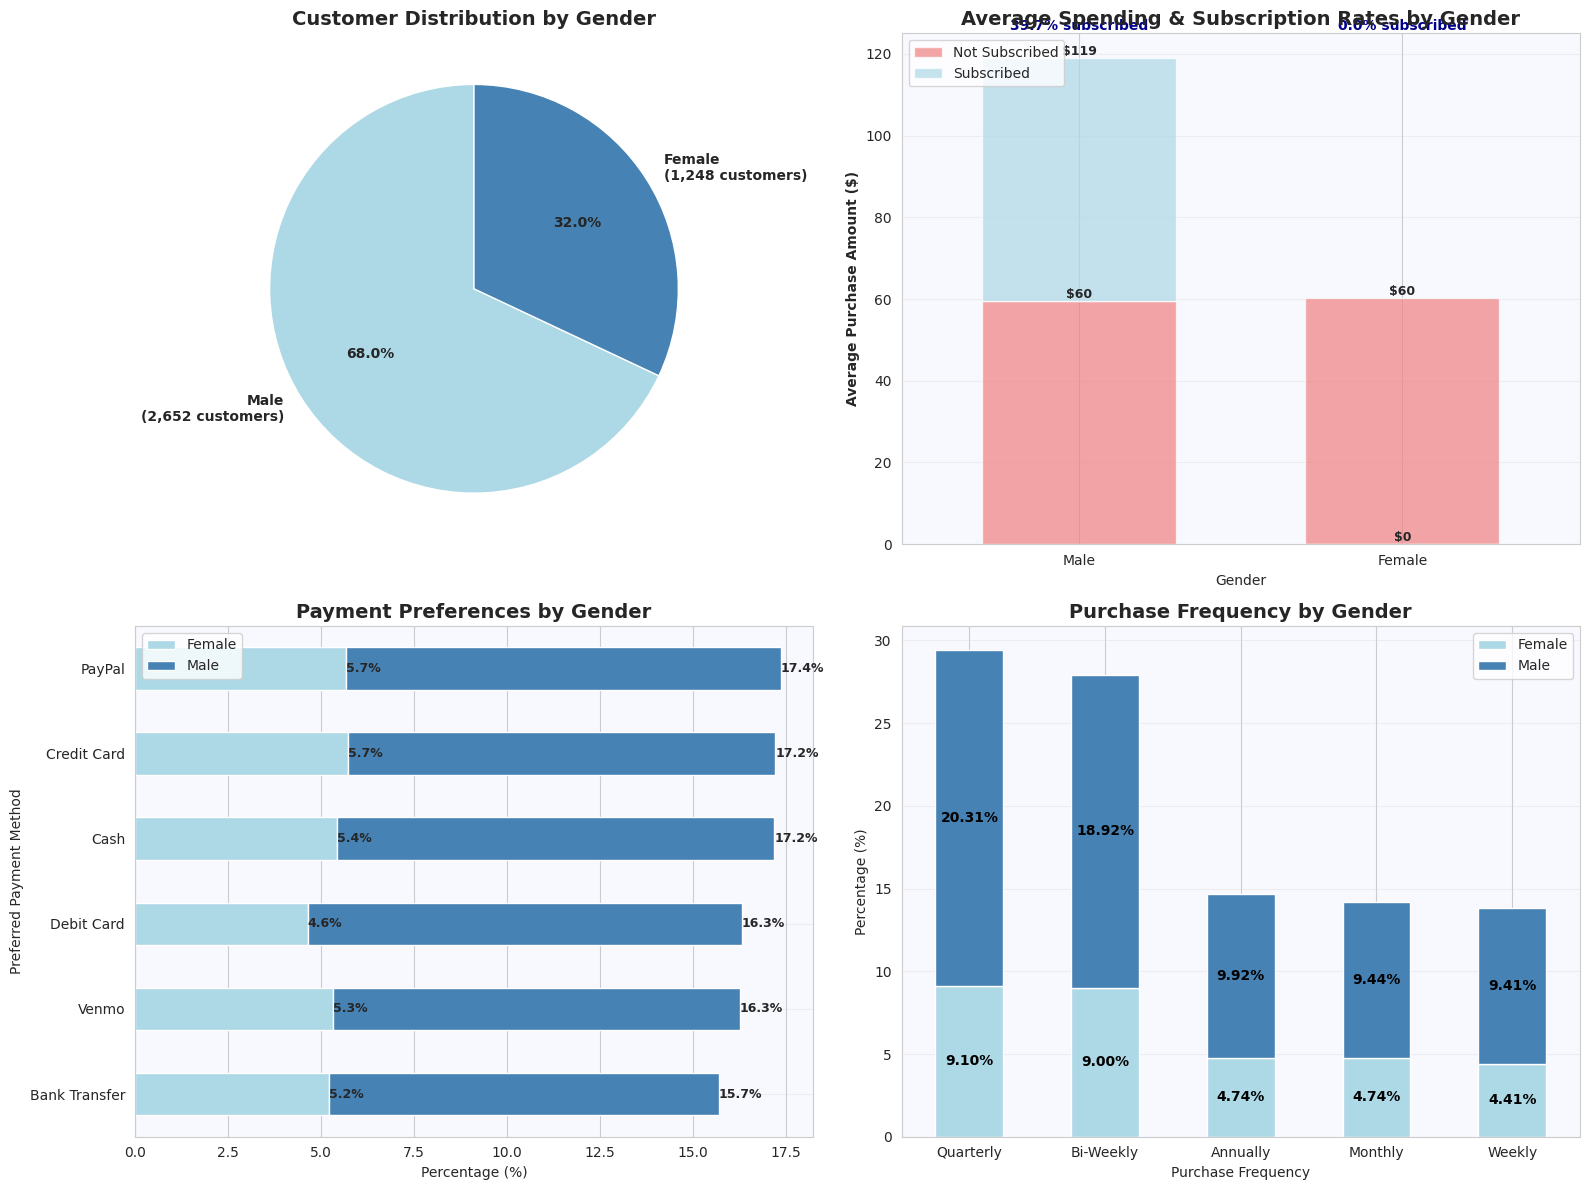

Subscription Status by Gender (Counts):
Subscription Status    No   Yes   All
Gender                               
Female               1248     0  1248
Male                 1599  1053  2652
All                  2847  1053  3900
Male subscription rate: 39.7%
Female subscription rate: 0.0%
Subscription gap: 39.7%

FEMALE SUBSCRIPTION OPPORTUNITY
   Male subscription rate: 39.7%
   Female subscription rate: 0.0%
   Gap: 39.7 percentage points
   Additional female subscribers possible: 495
   Monthly revenue opportunity: $29,449


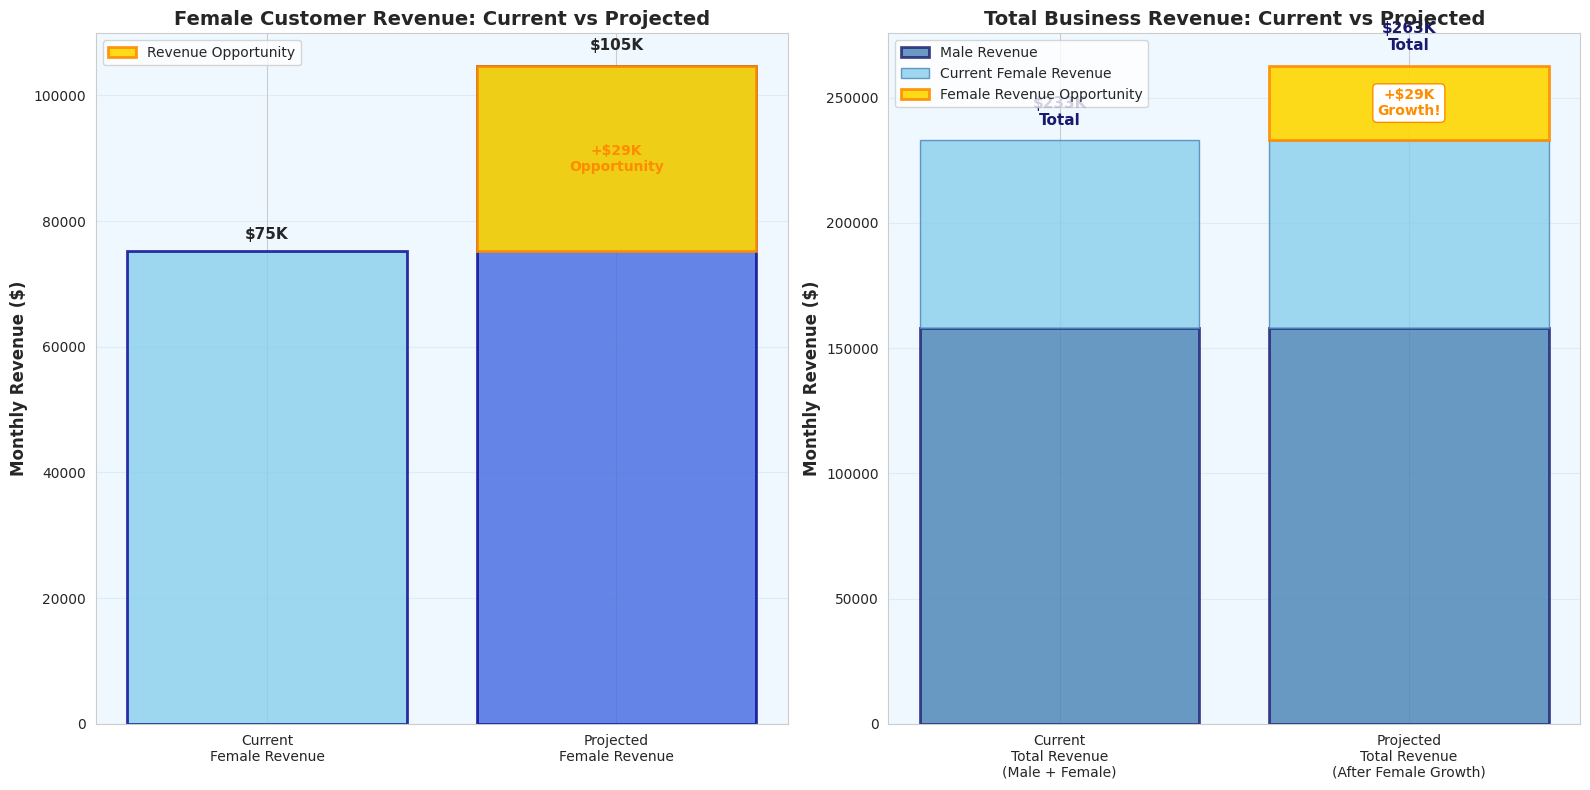

In [139]:
# Q2: Why are female customers not subscribing, and what is the revenue opportunity?

# Analyze subscription rates by gender
gender_subscription = pd.crosstab(df['Gender'], df['Subscription Status'], margins=True)
gender_subscription_pct = pd.crosstab(df['Gender'], df['Subscription Status'], normalize='index') * 100

print("Subscription Status by Gender (Counts):")
print(gender_subscription)

# Calculate the subscription gap
female_sub_rate = gender_subscription_pct.loc['Female', 'Yes']
male_sub_rate = gender_subscription_pct.loc['Male', 'Yes']
subscription_gap = male_sub_rate - female_sub_rate
print(f"   Male subscription rate: {male_sub_rate:.1f}%")

# Revenue opportunity analysis
female_customers = len(df[df['Gender'] == 'Female'])
female_non_subscribers = len(df[(df['Gender'] == 'Female') & (df['Subscription Status'] == 'No')])
avg_female_spending = df[df['Gender'] == 'Female']['Purchase Amount (USD)'].mean()
avg_subscriber_spending = df[df['Subscription Status'] == 'Yes']['Purchase Amount (USD)'].mean()

# Calculate potential revenue lift
potential_new_female_subscribers = female_non_subscribers * (subscription_gap / 100)
revenue_per_converted_customer = avg_subscriber_spending - avg_female_spending
total_revenue_opportunity = potential_new_female_subscribers * revenue_per_converted_customer * 12  # Annual

print(f"\nREVENUE OPPORTUNITY ANALYSIS:")
print(f"   Female customers not subscribing: {female_non_subscribers:,}")
print(f"   If female subscription rate matched male rate: +{potential_new_female_subscribers:.0f} subscribers")
print(f"   Average subscriber spends: ${avg_subscriber_spending:.2f}")
print(f"   Average female spends: ${avg_female_spending:.2f}")
print(f"   Annual revenue opportunity: ${total_revenue_opportunity:,.0f}")

# ==========================================
# Create visualizations - fixed layout
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Define blue color palette
blue_colors = ['lightblue', 'steelblue']

# CHART 1: Customer count by gender - PIE CHART
gender_counts = df['Gender'].value_counts().sort_values(ascending=False)
wedges, texts, autotexts = ax1.pie(gender_counts.values, labels=gender_counts.index, autopct='%1.1f%%',
                                   colors=blue_colors, startangle=90, textprops={'fontweight': 'bold'})
ax1.set_title('Customer Distribution by Gender', fontsize=14, fontweight='bold')

# Add count labels
for i, (label, count) in enumerate(zip(gender_counts.index, gender_counts.values)):
    texts[i].set_text(f'{label}\n({count:,} customers)')

# CHART 2: COMBINED - Average spending and subscription rates by gender
gender_sub_spending = df.groupby(['Gender', 'Subscription Status'])['Purchase Amount (USD)'].mean().unstack()
gender_subscription_pct = pd.crosstab(df['Gender'], df['Subscription Status'], normalize='index') * 100

# Sort by total spending
gender_sub_spending['total'] = gender_sub_spending.sum(axis=1)
gender_sub_spending = gender_sub_spending.sort_values('total', ascending=False).drop('total', axis=1)
gender_subscription_pct = gender_subscription_pct.reindex(gender_sub_spending.index)

# Bar chart for spending only
bars = gender_sub_spending.plot(kind='bar', stacked=True, ax=ax2, color=['lightcoral', 'lightblue'], alpha=0.7, width=0.6)
ax2.set_ylabel('Average Purchase Amount ($)', fontweight='bold')
ax2.set_title('Average Spending & Subscription Rates by Gender', fontsize=14, fontweight='bold')
ax2.legend(['Not Subscribed', 'Subscribed'], loc='upper left')
ax2.tick_params(axis='x', rotation=0)

# Add value labels for spending bars
for container in ax2.containers:
    ax2.bar_label(container, fmt='$%.0f', fontsize=9, fontweight='bold')

# Add subscription rate text labels above bars
subscription_yes_rates = gender_subscription_pct['Yes']
bar_positions = range(len(subscription_yes_rates))
max_height = gender_sub_spending.sum(axis=1).max()

for i, (gender, rate) in enumerate(subscription_yes_rates.items()):
    ax2.text(i, max_height + max_height*0.05, f'{rate:.1f}% subscribed',
             ha='center', va='bottom', fontweight='bold', color='darkblue', fontsize=10)

# CHART 3: Payment preferences by gender (both genders, no subscription status)
gender_payment = pd.crosstab(df['Gender'], df['Preferred Payment Method'], normalize='all') * 100

# Sort payment methods by total usage (largest to smallest)
payment_totals = df['Preferred Payment Method'].value_counts().sort_values(ascending=True)
gender_payment = gender_payment[payment_totals.index]

bars3 = gender_payment.T.plot(kind='barh', stacked=True, ax=ax3, color=blue_colors)
ax3.set_title('Payment Preferences by Gender', fontsize=14, fontweight='bold')
ax3.set_xlabel('Percentage (%)')
ax3.legend(['Female', 'Male'])
#ax3.tick_params(axis='x', rotation=45)

# Add value labels
for container in ax3.containers:
    ax3.bar_label(container, fmt='%.1f%%', fontsize=9, fontweight='bold')

# CHART 4: Purchase frequency by gender (both genders, no subscription status)
gender_frequency = pd.crosstab(df['Gender'], df['Frequency of Purchases'], normalize='all') * 100

# Sort frequency categories by total usage (largest to smallest)
freq_totals = df['Frequency of Purchases'].value_counts().sort_values(ascending=False)
gender_frequency = gender_frequency[freq_totals.index]

bars4 = gender_frequency.T.plot(kind='bar', stacked=True, ax=ax4, color=blue_colors)
ax4.set_title('Purchase Frequency by Gender', fontsize=14, fontweight='bold')
ax4.set_ylabel('Percentage (%)')
ax4.set_xlabel('Purchase Frequency')
ax4.legend(['Female', 'Male'])
ax4.tick_params(axis='x', rotation=0)

# Add percentage labels inside each segment (like your reference image)
for i, freq in enumerate(gender_frequency.columns):
    female_val = gender_frequency.loc['Female', freq]
    male_val = gender_frequency.loc['Male', freq]

    # Female segment (bottom)
    if female_val > 3:  # Only show if segment is large enough
        ax4.text(i, female_val/2, f'{female_val:.2f}%',
                ha='center', va='center', fontsize=10, fontweight='bold', color='black')

    # Male segment (top)
    if male_val > 3:  # Only show if segment is large enough
        ax4.text(i, female_val + male_val/2, f'{male_val:.2f}%',
                ha='center', va='center', fontsize=10, fontweight='bold', color='black')

# Style all charts with light blue background
for ax in [ax1, ax2, ax3, ax4]:
    ax.set_facecolor('#F8F8FF')
    if ax != ax1:  # Don't add grid to pie chart
        ax.grid(axis='y', alpha=0.3, color='lightgray')

plt.tight_layout()
plt.show()

# Analysis data
print("Subscription Status by Gender (Counts):")
print(gender_subscription)

if 'Female' in gender_subscription_pct.index and 'Male' in gender_subscription_pct.index:
    female_sub_rate = gender_subscription_pct.loc['Female', 'Yes']
    male_sub_rate = gender_subscription_pct.loc['Male', 'Yes']
    subscription_gap = male_sub_rate - female_sub_rate
    print(f"Male subscription rate: {male_sub_rate:.1f}%")
    print(f"Female subscription rate: {female_sub_rate:.1f}%")
    print(f"Subscription gap: {subscription_gap:.1f}%")

# ==============================

# SIMPLE FEMALE SUBSCRIPTION REVENUE PROJECTION
print("\nFEMALE SUBSCRIPTION OPPORTUNITY")
print("="*55)

# Calculate the key metrics simply
male_sub_rate = (df[df['Gender'] == 'Male']['Subscription Status'] == 'Yes').mean() * 100
female_sub_rate = (df[df['Gender'] == 'Female']['Subscription Status'] == 'Yes').mean() * 100

total_females = len(df[df['Gender'] == 'Female'])
current_female_subs = len(df[(df['Gender'] == 'Female') & (df['Subscription Status'] == 'Yes')])

# If females subscribed at male rate, how many more subscribers?
target_female_subs = int(total_females * (male_sub_rate / 100))
additional_subs = target_female_subs - current_female_subs

# Revenue calculations
avg_subscriber_spend = df[df['Subscription Status'] == 'Yes']['Purchase Amount (USD)'].mean()
current_female_revenue = len(df[df['Gender'] == 'Female']) * df[df['Gender'] == 'Female']['Purchase Amount (USD)'].mean()
additional_revenue = additional_subs * avg_subscriber_spend
projected_female_revenue = current_female_revenue + additional_revenue

print(f"   Male subscription rate: {male_sub_rate:.1f}%")
print(f"   Female subscription rate: {female_sub_rate:.1f}%")
print(f"   Gap: {male_sub_rate - female_sub_rate:.1f} percentage points")
print(f"   Additional female subscribers possible: {additional_subs:,}")
print(f"   Monthly revenue opportunity: ${additional_revenue:,.0f}")

# Create simple, clean visualizations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# CHART 1: Simple Revenue Comparison (Current vs Projected)
revenue_categories = ['Current\nFemale Revenue', 'Projected\nFemale Revenue']
revenue_values = [current_female_revenue, projected_female_revenue]
revenue_colors = ['#87CEEB', '#4169E1']

bars1 = ax1.bar(revenue_categories, revenue_values, color=revenue_colors, alpha=0.8,
                edgecolor='darkblue', linewidth=2)

# Add the opportunity as a highlighted section
ax1.bar(['Projected\nFemale Revenue'], [additional_revenue],
        bottom=[current_female_revenue], color='#FFD700', alpha=0.9,
        edgecolor='#FF8C00', linewidth=2, label='Revenue Opportunity')

ax1.set_ylabel('Monthly Revenue ($)', fontweight='bold', fontsize=12)
ax1.set_title('Female Customer Revenue: Current vs Projected', fontweight='bold', fontsize=14)
ax1.legend()

# Add value labels
for i, bar in enumerate(bars1):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, height + height*0.02,
             f'${height/1000:.0f}K', ha='center', va='bottom', fontweight='bold', fontsize=11)

# Add opportunity value label
ax1.text(1, current_female_revenue + additional_revenue/2,
         f'+${additional_revenue/1000:.0f}K\nOpportunity', ha='center', va='center',
         fontweight='bold', color='#FF8C00', fontsize=10)

# CHART 2: Total Business Revenue - Male + Female (Current vs Projected)
# Calculate male revenue for comparison
total_males = len(df[df['Gender'] == 'Male'])
current_male_revenue = total_males * df[df['Gender'] == 'Male']['Purchase Amount (USD)'].mean()

# Total business revenue
current_total_revenue = current_male_revenue + current_female_revenue
projected_total_revenue = current_male_revenue + projected_female_revenue

revenue_comparison = ['Current\nTotal Revenue\n(Male + Female)', 'Projected\nTotal Revenue\n(After Female Growth)']
revenue_values = [current_total_revenue, projected_total_revenue]

# Create stacked bars to show male vs female contribution
male_portion = [current_male_revenue, current_male_revenue]
female_current_portion = [current_female_revenue, current_female_revenue]
female_additional_portion = [0, additional_revenue]

# Male revenue (dark blue base)
bars2a = ax2.bar(revenue_comparison, male_portion, color='#4682B4', alpha=0.8,
                 edgecolor='#191970', linewidth=2, label='Male Revenue')

# Current female revenue (medium blue)
bars2b = ax2.bar(revenue_comparison, female_current_portion, bottom=male_portion,
                 color='#87CEEB', alpha=0.8, edgecolor='#4682B4', linewidth=1,
                 label='Current Female Revenue')

# Additional female revenue opportunity (golden highlight)
bars2c = ax2.bar([revenue_comparison[1]], [female_additional_portion[1]],
                 bottom=[male_portion[1] + female_current_portion[1]],
                 color='#FFD700', alpha=0.9, edgecolor='#FF8C00', linewidth=2,
                 label='Female Revenue Opportunity')

ax2.set_ylabel('Monthly Revenue ($)', fontweight='bold', fontsize=12)
ax2.set_title('Total Business Revenue: Current vs Projected', fontweight='bold', fontsize=14)
ax2.legend(loc='upper left')

# Add total value labels on top of bars
ax2.text(0, current_total_revenue + current_total_revenue*0.02,
         f'${current_total_revenue/1000:.0f}K\nTotal', ha='center', va='bottom',
         fontweight='bold', fontsize=11, color='#191970')
ax2.text(1, projected_total_revenue + projected_total_revenue*0.02,
         f'${projected_total_revenue/1000:.0f}K\nTotal', ha='center', va='bottom',
         fontweight='bold', fontsize=11, color='#191970')

# Add opportunity callout
ax2.text(1, current_total_revenue + additional_revenue/2,
         f'+${additional_revenue/1000:.0f}K\nGrowth!', ha='center', va='center',
         fontweight='bold', color='#FF8C00', fontsize=10,
         bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='#FF8C00'))

# Style both charts with light blue background
ax1.set_facecolor('#F0F8FF')
ax2.set_facecolor('#F0F8FF')
ax1.grid(axis='y', alpha=0.3, color='lightblue')
ax2.grid(axis='y', alpha=0.3, color='lightblue')

plt.tight_layout()
plt.show()

**Most customers purchase Quarterly or Bi-Weekly, composing 29.4% and 28%** of the customer base, respectively. This purchase frequency behavior is consistent for both genders.

### **Q3: Are frequent shoppers also high spenders?**

🔄 Purchase Behavior by Shopping Frequency:
                        Avg_Purchase_Amount  Transaction_Count  \
Frequency of Purchases                                           
Weekly                                58.97                539   
Bi-Weekly                             59.88               1089   
Monthly                               59.33                553   
Quarterly                             60.03               1147   
Annually                              60.17                572   

                        Avg_Previous_Purchases  Unique_Customers  
Frequency of Purchases                                            
Weekly                                   25.77               539  
Bi-Weekly                                25.03              1089  
Monthly                                  25.28               553  
Quarterly                                25.89              1147  
Annually                                 24.56               572  

💎 LIFETIME VALUE ANALYSI

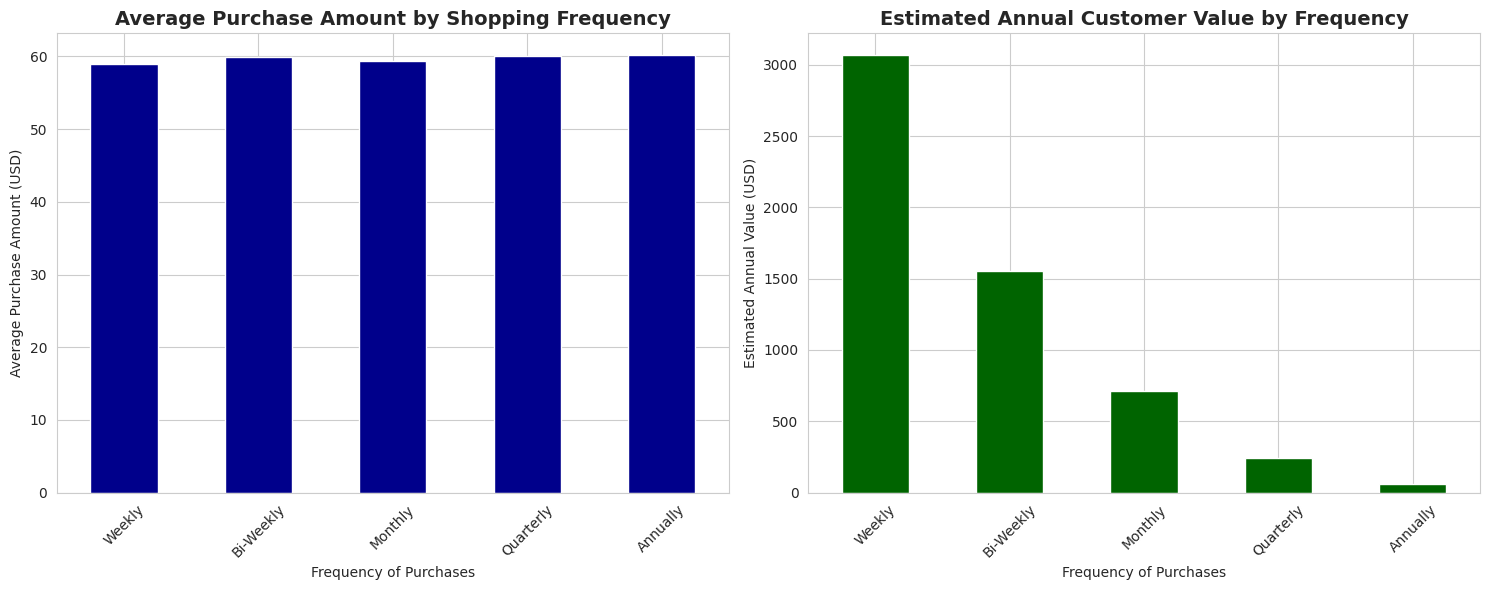

In [143]:
#Q4: Frequency vs. ACV

# Analyze frequency vs spending
frequency_analysis = df.groupby('Frequency of Purchases').agg({
    'Purchase Amount (USD)': ['mean', 'count'],
    'Previous Purchases': 'mean',
    'Customer ID': 'nunique'
}).round(2)

frequency_analysis.columns = ['Avg_Purchase_Amount', 'Transaction_Count', 'Avg_Previous_Purchases', 'Unique_Customers']

# Sort by frequency (custom order)
frequency_order = ['Weekly', 'Bi-Weekly', 'Monthly', 'Quarterly', 'Annually']
frequency_analysis = frequency_analysis.reindex([f for f in frequency_order if f in frequency_analysis.index])

print("🔄 Purchase Behavior by Shopping Frequency:")
print(frequency_analysis)

# Calculate lifetime value
frequency_analysis['Estimated_Annual_Purchases'] = frequency_analysis.apply(lambda row:
    52 if row.name == 'Weekly' else
    26 if row.name == 'Bi-Weekly' else
    12 if row.name == 'Monthly' else
    4 if row.name == 'Quarterly' else
    1 if row.name == 'Annually' else 12, axis=1)

frequency_analysis['Estimated_Annual_Value'] = (frequency_analysis['Avg_Purchase_Amount'] *
                                               frequency_analysis['Estimated_Annual_Purchases'])

print(f"\n💎 LIFETIME VALUE ANALYSIS:")
print(frequency_analysis[['Avg_Purchase_Amount', 'Estimated_Annual_Purchases', 'Estimated_Annual_Value']])

# Find the paradox
highest_ltv = frequency_analysis['Estimated_Annual_Value'].idxmax()
highest_per_purchase = frequency_analysis['Avg_Purchase_Amount'].idxmax()

print(f"\n")
print(f"="*70)
print(f"Highest per-purchase spending: {highest_per_purchase} shoppers (${frequency_analysis.loc[highest_per_purchase, 'Avg_Purchase_Amount']:.2f})")
print(f"Highest lifetime value: {highest_ltv} shoppers (${frequency_analysis.loc[highest_ltv, 'Estimated_Annual_Value']:.2f}/year)")

# Frequency visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# 1. Average purchase amount by frequency
frequency_analysis['Avg_Purchase_Amount'].plot(kind='bar', ax=ax1, color='darkblue')
ax1.set_title('Average Purchase Amount by Shopping Frequency', fontsize=14, fontweight='bold')
ax1.set_ylabel('Average Purchase Amount (USD)')
ax1.tick_params(axis='x', rotation=45)

# 2. Estimated annual value by frequency
frequency_analysis['Estimated_Annual_Value'].plot(kind='bar', ax=ax2, color='darkgreen')
ax2.set_title('Estimated Annual Customer Value by Frequency', fontsize=14, fontweight='bold')
ax2.set_ylabel('Estimated Annual Value (USD)')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

💡Weekly shoppers are more valuable despite lower per-purchase spending.

# **Customer Digital Twins**

## **Customer Profiling**

In [102]:
print("\nBUILDING A SIMPLIFIED DIGITAL TWIN")
print("="*55)
print("Create customer profiles by aggregating relevant features.")

# Step 1: Twin Aggregated Characteristics
print("\nSTEP 1: Digital Twin Characteristics Definition")
print("-" * 50)

# For this part, I used common profiling algorithms in aggregating the features: psychographic, behavioral, demographic, geographic)

twin_characteristics = {
    'Demographics': ['Age', 'Gender', 'Region', 'Location'], # demo + geo
    'Purchase Behavior': ['Purchase Amount (USD)', 'Previous Purchases', 'Frequency of Purchases'], #behavioral - for metrics like churn, retention
    'Product Preferences': ['Category', 'Size', 'Color', 'Season'], # psychographic - interests
    'Engagement': ['Review Rating', 'Subscription Status' 'Discount Applied'], #behavioral - for metrics like churn, retention
    'Logistical Preferences': ['Payment Method', 'Shipping Type']  #behavioral - for metrics like churn, retention
}

print("DIGITAL TWIN CHARACTERISTICS:")
for category, features in twin_characteristics.items():
    print(f"\n{category}:")
    for feature in features:
        print(f"  • {feature}")



BUILDING A SIMPLIFIED DIGITAL TWIN
Create customer profiles by aggregating relevant features.

STEP 1: Digital Twin Characteristics Definition
--------------------------------------------------
DIGITAL TWIN CHARACTERISTICS:

Demographics:
  • Age
  • Gender
  • Region
  • Location

Purchase Behavior:
  • Purchase Amount (USD)
  • Previous Purchases
  • Frequency of Purchases

Product Preferences:
  • Category
  • Size
  • Color
  • Season

Engagement:
  • Review Rating
  • Subscription StatusDiscount Applied

Logistical Preferences:
  • Payment Method
  • Shipping Type


In [111]:
# Step 2: Function for customer profiles

def create_digital_twin_profile(customer_row):

    customer_id = customer_row['Customer ID']

    # Demographics Profile
    demographics = {
        'age': customer_row['Age'],
        'gender': customer_row['Gender'],
        'region': customer_row['Region'],
        'location': customer_row['Location'],
        'profile_summary': f"{customer_row['Age']}-year-old {customer_row['Gender']} from {customer_row['Location']}, {customer_row['Region']}"
    }

    # Purchase Behavior Analysis
    purchase_behavior = {
        'current_purchase': customer_row['Purchase Amount (USD)'],
        'purchase_history': customer_row['Previous Purchases'],
        'frequency': customer_row['Frequency of Purchases'],
        'spending_tier': 'High' if customer_row['Purchase Amount (USD)'] >= df['Purchase Amount (USD)'].quantile(0.75)
                        else 'Medium' if customer_row['Purchase Amount (USD)'] >= df['Purchase Amount (USD)'].quantile(0.25)
                        else 'Low',
        'loyalty_level': 'High' if customer_row['Previous Purchases'] >= df['Previous Purchases'].quantile(0.75)
                        else 'Medium' if customer_row['Previous Purchases'] >= df['Previous Purchases'].quantile(0.25)
                        else 'Low'
    }

    # Product Preferences
    preferences = {
        'preferred_category': customer_row['Category'],
        'size': customer_row['Size'],
        'favorite_color': customer_row['Color'],
        'season': customer_row['Season'],
        'style_profile': f"Prefers buying {customer_row['Category']} in {customer_row['Color']}, size {customer_row['Size']} during {customer_row['Season']}"
    }

    # Engagement & Satisfaction
    engagement = {
        'subscription_status': customer_row['Subscription Status'],
        'discount_used': customer_row['Discount Applied'],
        'review_rating': customer_row['Review Rating'],
        'satisfaction_level': 'High' if customer_row['Review Rating'] > 4.0
                             else 'Medium' if customer_row['Review Rating'] > 3.0
                             else 'Low'
    }

    # Payment & Logistics Preferences
    logistics = {
        'payment_method': customer_row['Payment Method'],
        'shipping_preference': customer_row['Shipping Type'],
        #'discount_applied': customer_row['Promo Code Used']  # Using Promo Code Used for discount applied
    }

    # === Calculate Customer Lifetime Value ===
    # total revenue from customer * annual multiplier = CLV
    frequency_multiplier = {
        'Weekly': 52, 'Bi-Weekly': 26, 'Monthly': 12,
        'Quarterly': 4, 'Annually': 1
    }

    annual_frequency = frequency_multiplier.get(customer_row['Frequency of Purchases'], 12)
    estimated_clv = customer_row['Purchase Amount (USD)'] * annual_frequency

    # === Generate customer archetype and marketing strategy ===
    archetype, marketing_strategy = generate_customer_archetype(customer_row, purchase_behavior, engagement)

    # Complete Digital Twin Profile
    digital_twin = {
        'customer_id': customer_id,
        'demographics': demographics,
        'purchase_behavior': purchase_behavior,
        'product_preferences': preferences,
        'engagement_metrics': engagement,
        'logistics_preferences': logistics,
        'estimated_clv': estimated_clv,
        'customer_archetype': archetype,
        'marketing_strategy': marketing_strategy
    }

    return digital_twin

  # === Archetypes ===

def generate_customer_archetype(customer_row, purchase_behavior, engagement):

    # Determine customer profiles based on key characteristics
    is_subscriber = customer_row['Subscription Status'] == 'Yes'
    high_spender = purchase_behavior['spending_tier'] == 'High'
    loyal = purchase_behavior['loyalty_level'] == 'High'
    satisfied = engagement['satisfaction_level'] == 'High'
    frequent = customer_row['Frequency of Purchases'] in ['Weekly', 'Fortnightly', 'Monthly']

    # Customer Archetypes
    if is_subscriber and high_spender and loyal:
        archetype = "Premium Buyer"
        strategy = "Premium-first, exclusive previews, personalization service, loyalty rewards"
    elif is_subscriber and frequent:
        archetype = "Loyal Regular"
        strategy = "Convenience features, auto-reorder, bulk discounts, frequency-based rewards"
    elif high_spender and not is_subscriber:
        archetype = "One-time Big Spender"
        strategy = "Push subscription conversion campaigns, premium benefits, exclusive offers for bulk discounts"
    elif loyal and satisfied and not is_subscriber:
        archetype = "Conversion Opportunity"
        strategy = "Push subscription conversion campaigns such as trials, loyalty incentives, rating incentives"
    elif frequent and not high_spender:
        archetype = "Volume Buyer"
        strategy = "Bulk discounts, value packs, frequency-based rewards"
    elif not loyal and not frequent:
        archetype = "Occasional Shopper"
        strategy = "Re-engagement campaigns, seasonal promotions"
    else:
        archetype = "Balanced Customer"
        strategy = "General promotions, category-specific offers, engagement campaigns, subscription campaigns"

    return archetype, strategy

# Strategy: Pick customers that represent different segments
selected_customers = []


# 1. High-spending non-subscriber
high_spend_nonsubscribers = df[(df['Subscription Status'] == 'No') &
                           (df['Purchase Amount (USD)'] > df['Purchase Amount (USD)'].quantile(0.75))]
if len(high_spend_nonsubscribers) > 0:
    selected_customers.append(high_spend_nonsubscribers.iloc[0])

# 2. High-spending non-subscriber
high_spend_non_subscribers = df[(df['Subscription Status'] == 'No') &
                               (df['Purchase Amount (USD)'] > df['Purchase Amount (USD)'].quantile(0.75))]
if len(high_spend_non_subscribers) > 0:
    selected_customers.append(high_spend_non_subscribers.iloc[0])

# 3. Frequent buyer (regardless of amount)
frequent_buyers = df[df['Frequency of Purchases'].isin(['Weekly', 'Fortnightly'])]
if len(frequent_buyers) > 0:
    selected_customers.append(frequent_buyers.iloc[0])

# 4. Loyal customer (high previous purchases)
loyal_customers = df[df['Previous Purchases'] > df['Previous Purchases'].quantile(0.75)]
if len(loyal_customers) > 0:
    selected_customers.append(loyal_customers.iloc[0])

# 5. Occasional low-spender (different segment)
occasional_customers = df[(df['Frequency of Purchases'].isin(['Quarterly', 'Annually'])) &
                         (df['Purchase Amount (USD)'] < df['Purchase Amount (USD)'].quantile(0.5))]
if len(occasional_customers) > 0:
    selected_customers.append(occasional_customers.iloc[0])

# 6. Add one more diverse customer if needed
if len(selected_customers) < 5:
    # Pick a random customer not already selected
    remaining_customers = df[~df.index.isin([c.name for c in selected_customers])]
    if len(remaining_customers) > 0:
        selected_customers.append(remaining_customers.iloc[0])

print(f"Selected {len(selected_customers)} diverse customers for digital twin creation")

#selected_customers = df.sample(5, random_state=42)

# Step 4: Generate and display digital twin profiles

digital_twins = []

for i, customer in enumerate(selected_customers, 1):
    print(f"\n" + "="*70)
    print(f"DIGITAL TWIN #{i}")
    print("="*70)

    # Create digital twin profile
    twin_profile = create_digital_twin_profile(customer)
    digital_twins.append(twin_profile)

    # Display profile in readable format
    print(f"CUSTOMER ID: {twin_profile['customer_id']}")

    print(f"\nDEMOGRAPHICS:")
    demo = twin_profile['demographics']
    print(f"   • Profile: {demo['profile_summary']}")
    print(f"   • Age: {demo['age']}")
    print(f"   • Gender: {demo['gender']}")
    print(f"   • Region: {demo['region']}")

    print(f"\nPURCHASE BEHAVIOR:")
    purchase = twin_profile['purchase_behavior']
    print(f"   • Current Purchase: ${purchase['current_purchase']:.2f}")
    print(f"   • Purchase History: {purchase['purchase_history']} previous purchases")
    print(f"   • Frequency: {purchase['frequency']}")
    print(f"   • Spending Tier: {purchase['spending_tier']}")
    print(f"   • Loyalty Level: {purchase['loyalty_level']}")

    print(f"\nPRODUCT PREFERENCES:")
    prefs = twin_profile['product_preferences']
    print(f"   • Style Profile: {prefs['style_profile']}")
    print(f"   • Preferred Category: {prefs['preferred_category']}")
    print(f"   • Size: {prefs['size']}")
    print(f"   • Favorite Color: {prefs['favorite_color']}")

    print(f"\nENGAGEMENT:")
    engagement = twin_profile['engagement_metrics']
    print(f"   • Subscription Status: {engagement['subscription_status']}")
    print(f"   • Review Rating: {engagement['review_rating']:.1f}")
    print(f"   • Satisfaction Level: {engagement['satisfaction_level']}")
    #print(f"   • Uses Promos: {engagement['uses_promos']}")

    print(f"\nLOGISTICAL PREFERENCES:")
    logistics = twin_profile['logistics_preferences']
    print(f"   • Payment Method: {logistics['payment_method']}")
    #print(f"   • Preferred Payment: {logistics['preferred_payment']}")
    print(f"   • Shipping Preference: {logistics['shipping_preference']}")
    #print(f"   • Discount Sensitive: {logistics['discount_sensitive']}")

    print(f"\nCUSTOMER TYPE:")
    print(f"   • Customer Archetype: {twin_profile['customer_archetype']}")
    print(f"   • Estimated CLV (Annual): ${twin_profile['estimated_clv']:,.0f}")

    print(f"\nMARKETING STRATEGY:")
    print(f"   • Recommended Approach: {twin_profile['marketing_strategy']}")

    print(f"\n" + "-"*70)

archetypes = [twin['customer_archetype'] for twin in digital_twins]
print(f"\nCUSTOMER PROFILES IDENTIFIED:")
for i, archetype in enumerate(set(archetypes), 1):
    count = archetypes.count(archetype)
    print(f"   {i}. {archetype}: {count} customer{'s' if count != 1 else ''}")

# Calculate total estimated CLV
total_clv = sum(twin['estimated_clv'] for twin in digital_twins)
avg_clv = total_clv / len(digital_twins)
print(f"\nCUSTOMER VALUE INSIGHTS:")
print(f"   • Total estimated CLV (5 customers): ${total_clv:,.0f}")
print(f"   • Average CLV: ${avg_clv:,.0f}")
print(f"   • CLV Range: ${min(twin['estimated_clv'] for twin in digital_twins):,.0f} - ${max(twin['estimated_clv'] for twin in digital_twins):,.0f}")

Selected 5 diverse customers for digital twin creation

DIGITAL TWIN #1
CUSTOMER ID: 1055

DEMOGRAPHICS:
   • Profile: 18-year-old Male from Arkansas, South
   • Age: 18
   • Gender: Male
   • Region: South

PURCHASE BEHAVIOR:
   • Current Purchase: $96.00
   • Purchase History: 48 previous purchases
   • Frequency: Quarterly
   • Spending Tier: High
   • Loyalty Level: High

PRODUCT PREFERENCES:
   • Style Profile: Prefers buying Clothing in Cyan, size L during Winter
   • Preferred Category: Clothing
   • Size: L
   • Favorite Color: Cyan

ENGAGEMENT:
   • Subscription Status: No
   • Review Rating: 4.9
   • Satisfaction Level: High

LOGISTICAL PREFERENCES:
   • Payment Method: Debit Card
   • Shipping Preference: Express

CUSTOMER TYPE:
   • Customer Archetype: One-time Big Spender
   • Estimated CLV (Annual): $384

MARKETING STRATEGY:
   • Recommended Approach: Push subscription conversion campaigns, premium benefits, exclusive offers for bulk discounts

---------------------------

## **KMeans Cluster Analysis**

K-MEANS CLUSTERING ANALYSIS
Feature Selection and Preparation
----------------------------------------
Features selected: ['Purchase Amount (USD)', 'Previous Purchases', 'Age', 'Review Rating', 'Subscription Status_num']
Dataset shape: (3900, 5)
Features have been standardized

Determine Optimal k using Elbow Method
---------------------------------------------


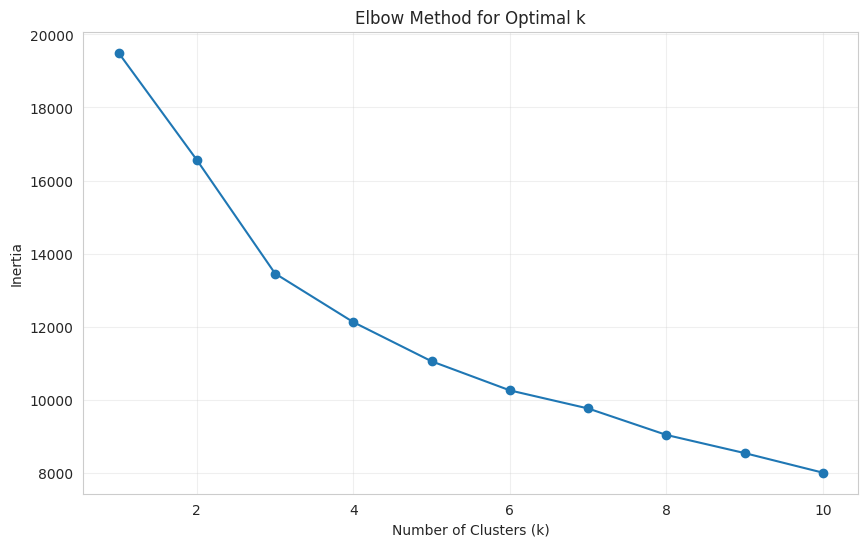

Inertia values:
k=1: 19500.00
k=2: 16565.13
k=3: 13453.77
k=4: 12121.78
k=5: 11049.54
k=6: 10253.05
k=7: 9757.30
k=8: 9032.54
k=9: 8535.53
k=10: 7998.53

Silhouette Score Analysis
------------------------------


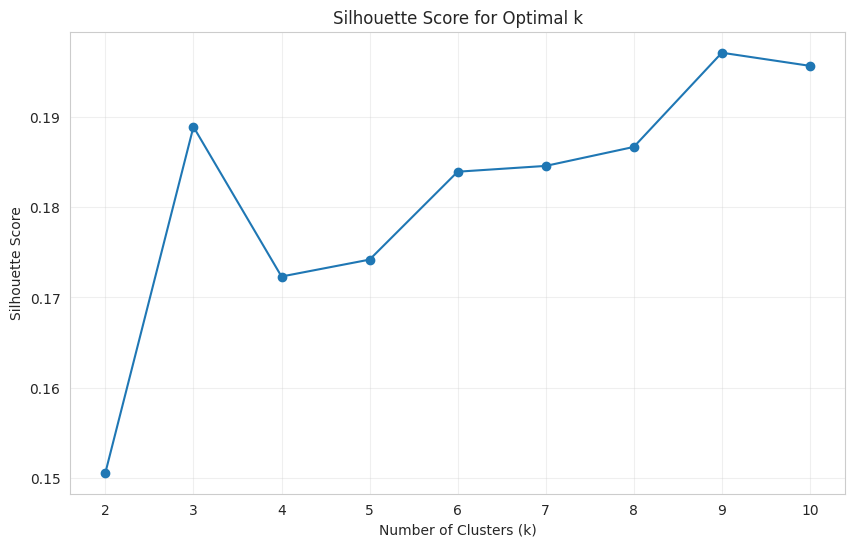

Silhouette scores:
k=2: 0.151
k=3: 0.189
k=4: 0.172
k=5: 0.174
k=6: 0.184
k=7: 0.185
k=8: 0.187
k=9: 0.197
k=10: 0.196


In [112]:
# K-MEANS CLUSTER ANALYSIS

# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Step 1: Feature selection and preparation
print("Feature Selection and Preparation")
print("-" * 40)

# Select features for clustering
feature_columns = ['Purchase Amount (USD)', 'Previous Purchases', 'Age', 'Review Rating', 'Subscription Status_num']
X = df[feature_columns].values

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X = X_scaled  # Use scaled features

print(f"Features selected: {feature_columns}")
print(f"Dataset shape: {X.shape}")
print("Features have been standardized")

# Step 2: Determine optimal number of clusters using Elbow Method
print("\nDetermine Optimal k using Elbow Method")
print("-" * 45)

# Calculate inertia for different k values
inertia = []
k_range = range(1, 11)  # Test k values from 1 to 10

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Method results
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True, alpha=0.3)
plt.show()

print("Inertia values:")
for k, inert in zip(k_range, inertia):
    print(f"k={k}: {inert:.2f}")

print("\nSilhouette Score Analysis")
print("-" * 30)

# Calculate silhouette scores for different k values
silhouette_avg = []
for k in k_range[1:]:  # Silhouette Score is not defined for k=1
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X)
    labels = kmeans.labels_
    silhouette_avg.append(silhouette_score(X, labels))

# Plot the Silhouette Score results
plt.figure(figsize=(10, 6))
plt.plot(k_range[1:], silhouette_avg, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k')
plt.grid(True, alpha=0.3)
plt.show()

print("Silhouette scores:")
for k, score in zip(k_range[1:], silhouette_avg):
    print(f"k={k}: {score:.3f}")

Identify optimal k using **Elbow Method**.


Applying K-Means with k=3
----------------------------------------
Clustering applied with k=3

Cluster distribution:
Cluster 0: 1429 customers
Cluster 1: 1418 customers
Cluster 2: 1053 customers

Cluster Centers (Original Scale):
   Purchase Amount (USD)  Previous Purchases    Age  Review Rating  \
0                  57.17               25.31  45.45           3.15   
1                  62.60               24.84  42.55           4.37   
2                  59.49               26.08  44.23           3.74   

   Subscription Status_num  
0                      0.0  
1                      0.0  
2                      1.0  

Step 5: Cluster Visualizations
------------------------------


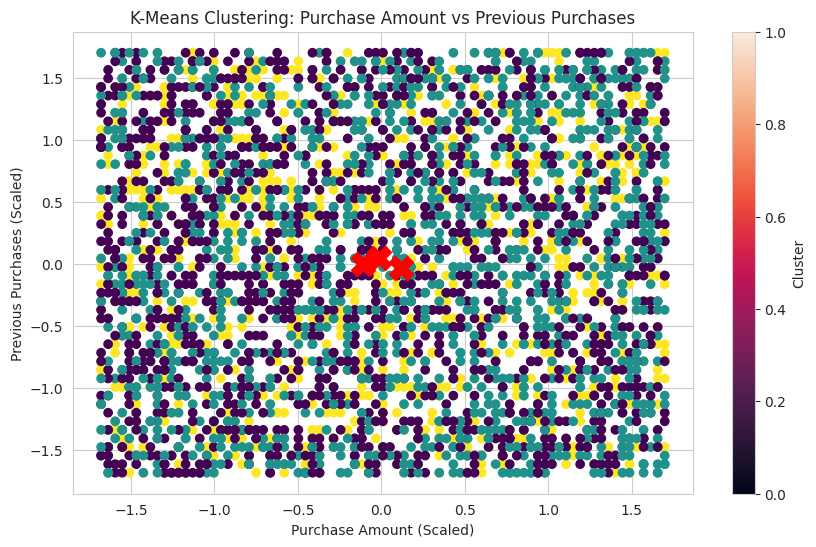

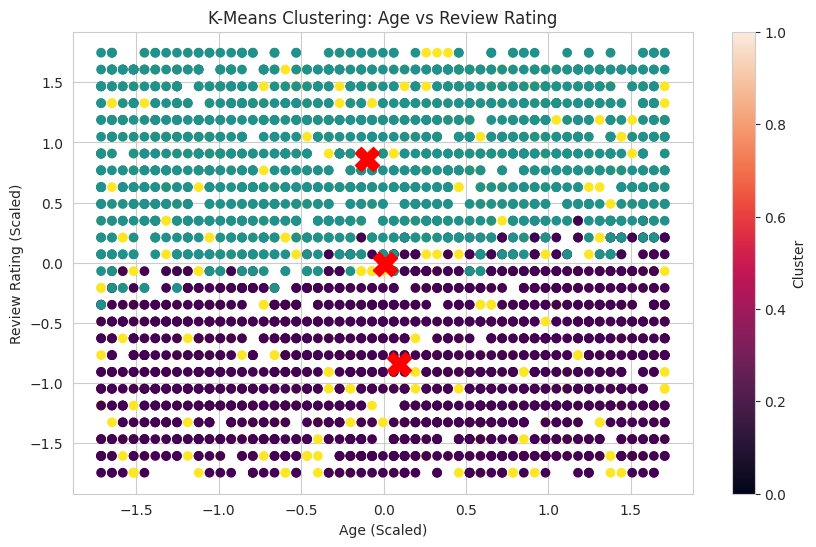


Cluster Analysis:
---------------

Cluster 0 (1429 customers):
  Purchase Amount (USD): 57.12
  Previous Purchases: 25.26
  Age: 45.44
  Review Rating: 3.14
  Subscription Status_num: 0.00
  Subscription Rate: 0.0%

Cluster 1 (1418 customers):
  Purchase Amount (USD): 62.63
  Previous Purchases: 24.90
  Age: 42.56
  Review Rating: 4.37
  Subscription Status_num: 0.00
  Subscription Rate: 0.0%

Cluster 2 (1053 customers):
  Purchase Amount (USD): 59.49
  Previous Purchases: 26.08
  Age: 44.23
  Review Rating: 3.74
  Subscription Status_num: 1.00
  Subscription Rate: 100.0%
Optimal k=3 determined using Elbow Method.


In [113]:
# ===========================
optimal_k = 3
# ===========================

# Apply K-Means clustering with the optimal k
print(f"\nApplying K-Means with k={optimal_k}")
print("-" * 40)
kmeans = KMeans(n_clusters=optimal_k, random_state=0)
kmeans.fit(X)

# Get cluster labels and centroids
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

# Add the cluster labels to the dataframe
df['Cluster'] = labels

print(f"Clustering applied with k={optimal_k}")
print("\nCluster distribution:")
cluster_counts = pd.Series(labels).value_counts().sort_index()
for cluster, count in cluster_counts.items():
    print(f"Cluster {cluster}: {count} customers")

# Display cluster centers in original scale
centroids_original = scaler.inverse_transform(centroids)
centroids_df = pd.DataFrame(centroids_original, columns=feature_columns)
print(f"\nCluster Centers (Original Scale):")
print(centroids_df.round(2))

# Step 5: Plotting the clustering results
print(f"\nStep 5: Cluster Visualizations")
print("-" * 30)

# Plot 1: Purchase Amount vs Previous Purchases
plt.figure(figsize=(10, 6))
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis')
plt.scatter(centroids[:, 0], centroids[:, 1], s=300, c='red', marker='X')
plt.title('K-Means Clustering: Purchase Amount vs Previous Purchases')
plt.xlabel('Purchase Amount (Scaled)')
plt.ylabel('Previous Purchases (Scaled)')
plt.colorbar(label='Cluster')
plt.show()

# Plot 2: Age vs Review Rating
plt.figure(figsize=(10, 6))
plt.scatter(X[:, 2], X[:, 3], c=labels, cmap='viridis')
plt.scatter(centroids[:, 2], centroids[:, 3], s=300, c='red', marker='X')
plt.title('K-Means Clustering: Age vs Review Rating')
plt.xlabel('Age (Scaled)')
plt.ylabel('Review Rating (Scaled)')
plt.colorbar(label='Cluster')
plt.show()

# Additional analysis: Cluster characteristics
print(f"\nCluster Analysis:")
print("-" * 15)

for cluster_id in range(optimal_k):
    cluster_data = df[df['Cluster'] == cluster_id]
    print(f"\nCluster {cluster_id} ({len(cluster_data)} customers):")

    # Calculate means for each feature
    for i, feature in enumerate(feature_columns):
        mean_val = cluster_data[feature].mean()
        print(f"  {feature}: {mean_val:.2f}")

    # Additional characteristics
    subscription_rate = (cluster_data['Subscription Status'] == 'Yes').mean() * 100
    print(f"  Subscription Rate: {subscription_rate:.1f}%")

print(f"Optimal k={optimal_k} determined using Elbow Method.")

# **Predicting Customer Purchase Propensity**

The likelihood of a customer to purchase within the next month can be answered by "Yes" or "No", however, this information is not provided by the dataset. In that case, proxy variables can be used by prioritizing features that would contribute to purchase likelihood.

Predictive models for classification tasks were performed in this section:
1. Logistic Regression
2. SVM
3. KNN
4. Naive Bayes
5. Random Forest

In [121]:
# Multicollinearity

from statsmodels.stats.outliers_influence import variance_inflation_factor

#df.info()

X = df[['Category_num', 'Purchase Amount (USD)','Region_num','Subscription Status_num','Previous Purchases', 'Frequency_num', 'Season_num']]

# create an empty dataframe
vif = pd.DataFrame()

# copy all the features of X in vif dataframe
vif["features"] = X.columns

# calculate VIF for all the variables
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif



,features,VIF Factor
0,Category_num,1.867041
1,Purchase Amount (USD),4.449407
2,Region_num,2.116484
3,Subscription Status_num,1.345997
4,Previous Purchases,3.319379
5,Frequency_num,1.892398
6,Season_num,2.484277


In [137]:
# C. PREDICTIVE MODELING
print("\n🤖 C. PREDICTIVE MODELING")
print("="*50)
print("Objective: Predict whether a customer is likely to make a purchase in the next month")
print("Proxy: Using 'Frequency of Purchases' to determine purchase likelihood")

# Import required libraries for modeling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tabulate import tabulate
import warnings

warnings.filterwarnings('ignore')

# Step 1: Create target variable based on purchase frequency
print("\n📊 STEP 1: Creating Target Variable")
print("-" * 35)

# Define high-frequency customers as likely to purchase next month
# Note: Using 'Fortnightly' (which was standardized from 'Bi-Weekly')
high_frequency = ['Weekly', 'Bi-Weekly', 'Monthly']  # These customers likely to purchase soon
low_frequency = ['Quarterly', 'Annually']  # These customers less likely to purchase next month

# Create binary target variable
df['Will_Purchase_Next_Month'] = df['Frequency of Purchases'].apply(
    lambda x: 1 if x in high_frequency else 0
)

target_distribution = df['Will_Purchase_Next_Month'].value_counts()
print("Target Variable Distribution:")
print(f"Will purchase next month (1): {target_distribution.get(1, 0):,} customers")
print(f"Won't purchase next month (0): {target_distribution.get(0, 0):,} customers")
print(f"Percentage likely to purchase: {(target_distribution.get(1, 0) / len(df) * 100):.1f}%")

# Step 2: Prepare features for modeling
print("\n🔧 STEP 2: Feature Engineering")
print("-" * 30)

feature_columns = ['Category_num',
                   'Purchase Amount (USD)',
                   'Region_num',
                   #'Subscription Status_num',
                   'Previous Purchases',
                   'Season_num']

# Create feature dataset
X = df[feature_columns].copy()

print(f"Selected features: {feature_columns}")
print(f"Features shape: {X.shape}")
print(f"Feature data types:")
for col in feature_columns:
    print(f"  {col}: {X[col].dtype}")

# Check for any missing values
missing_values = X.isnull().sum()
if missing_values.sum() > 0:
    print(f"\nMissing values detected:")
    print(missing_values[missing_values > 0])
else:
    print("\n✅ No missing values in features")

# Target variable
y = df['Will_Purchase_Next_Month']

# Step 3: Split data
print("\n📈 STEP 3: Train-Test Split")
print("-" * 25)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set: {X_train.shape[0]:,} samples")
print(f"Test set: {X_test.shape[0]:,} samples")

# Scale features for algorithms that need it
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 4: Train and evaluate models with comprehensive metrics
print("\n🎯 STEP 4&5: Model Training and Evaluation")
print("-" * 40)

# Import additional metrics
from sklearn.metrics import roc_auc_score
from scipy.stats import chi2

# Initialize models
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'SVM': SVC(random_state=42, probability=True),  # Enable probability for AUC
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=10),
    'Naive Bayes': GaussianNB()
}

# Function to calculate pseudo R-squared (McFadden's)
def calculate_pseudo_r2(y_true, y_prob):
    # Calculate log-likelihood of full model
    epsilon = 1e-15  # Small value to prevent log(0)
    y_prob_clipped = np.clip(y_prob, epsilon, 1 - epsilon)

    ll_full = np.sum(y_true * np.log(y_prob_clipped) + (1 - y_true) * np.log(1 - y_prob_clipped))

    # Calculate log-likelihood of null model (intercept only)
    p_null = np.mean(y_true)
    p_null_clipped = np.clip(p_null, epsilon, 1 - epsilon)
    ll_null = np.sum(y_true * np.log(p_null_clipped) + (1 - y_true) * np.log(1 - p_null_clipped))

    # McFadden's pseudo R-squared
    pseudo_r2 = 1 - (ll_full / ll_null)
    return pseudo_r2

# Function to calculate AIC
def calculate_aic(y_true, y_prob, n_params):
    epsilon = 1e-15
    y_prob_clipped = np.clip(y_prob, epsilon, 1 - epsilon)
    ll = np.sum(y_true * np.log(y_prob_clipped) + (1 - y_true) * np.log(1 - y_prob_clipped))
    aic = 2 * n_params - 2 * ll
    return aic

# Function to calculate adjusted R-squared (approximation for classification)
def calculate_adj_r2(pseudo_r2, n_samples, n_params):
    adj_r2 = 1 - ((1 - pseudo_r2) * (n_samples - 1) / (n_samples - n_params - 1))
    return adj_r2

# Store comprehensive results
results = {}
n_samples = len(X_test)

for name, model in models.items():

    # Determine number of parameters (approximation)
    if name == 'Random Forest':
        n_params = len(feature_columns) * 100  # Rough estimate for 100 trees
    elif name == 'Logistic Regression':
        n_params = len(feature_columns) + 1  # Coefficients + intercept
    elif name == 'SVM':
        n_params = len(X_train)  # In worst case, all samples are support vectors
    elif name == 'K-Nearest Neighbors':
        n_params = 5  # K=5, non-parametric but we need something for AIC
    else:  # Naive Bayes
        n_params = len(feature_columns) * 2  # Mean and variance for each feature

    # Train and predict
    if name in ['SVM', 'K-Nearest Neighbors', 'Logistic Regression', 'Naive Bayes']:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_prob = model.predict_proba(X_test_scaled)[:, 1]  # Probability of positive class
    else:  # Random Forest
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]

    # Calculate all metrics
    accuracy = accuracy_score(y_test, y_pred)

    # Confusion matrix for sensitivity and specificity
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0  # Recall/True Positive Rate
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # True Negative Rate

    # Pseudo R-squared
    pseudo_r2 = calculate_pseudo_r2(y_test, y_prob)

    # Adjusted R-squared
    adj_r2 = calculate_adj_r2(pseudo_r2, n_samples, n_params)

    # AIC
    aic = calculate_aic(y_test, y_prob, n_params)

    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'pseudo_r2': pseudo_r2,
        'adj_r2': adj_r2,
        'aic': aic,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'predictions': y_pred,
        'probabilities': y_prob
    }


# Create results DataFrame
results_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Pseudo R²': [results[model]['pseudo_r2'] for model in results.keys()],
    'Adj R²': [results[model]['adj_r2'] for model in results.keys()],
    'AIC': [results[model]['aic'] for model in results.keys()],
    'Accuracy': [results[model]['accuracy'] for model in results.keys()],
    'Sensitivity': [results[model]['sensitivity'] for model in results.keys()],
    'Specificity': [results[model]['specificity'] for model in results.keys()]
})

# Format the table nicely
#pd.set_option('display.float_format', '{:.4f}'.format)
#print(results_df.to_string(index=False))
print(tabulate(results_df, headers='keys', tablefmt='psql', showindex=False))

# Reset pandas display options
pd.reset_option('display.float_format')

# Find best model by accuracy
best_model_name = results_df.loc[results_df['Accuracy'].idxmax(), 'Model']
best_model_info = results[best_model_name]

print(f"\n🏆 BEST MODEL BY ACCURACY: {best_model_name}")
print(f"   Accuracy: {best_model_info['accuracy']:.4f}")
print(f"   Pseudo R²: {best_model_info['pseudo_r2']:.4f}")
print(f"   AIC: {best_model_info['aic']:.2f}")

# Model with best Pseudo R²
best_pseudo_r2_model = results_df.loc[results_df['Pseudo R²'].idxmax(), 'Model']
print(f"\n📈 BEST MODEL BY PSEUDO R²: {best_pseudo_r2_model}")
print(f"   Pseudo R²: {results_df.loc[results_df['Pseudo R²'].idxmax(), 'Pseudo R²']:.4f}")

# Model with lowest AIC (better)
best_aic_model = results_df.loc[results_df['AIC'].idxmin(), 'Model']
print(f"\n📉 BEST MODEL BY AIC: {best_aic_model}")
print(f"   AIC: {results_df.loc[results_df['AIC'].idxmin(), 'AIC']:.2f}")

# Step 6: Detailed evaluation of best model (by accuracy)
print(f"\n🔍 STEP 6: Detailed Analysis of Best Model ({best_model_name})")
print("-" * 55)

best_predictions = best_model_info['predictions']
print("Classification Report:")
print(classification_report(y_test, best_predictions, target_names=['Won\'t Purchase', 'Will Purchase']))


print(f"\nConfusion Matrix:")
cm = confusion_matrix(y_test, best_predictions)
print(f"                 Predicted")
print(f"               No    Yes")
print(f"Actual No    {cm[0,0]:4d}  {cm[0,1]:4d}")
print(f"       Yes   {cm[1,0]:4d}  {cm[1,1]:4d}")

# Step 7: Feature importance analysis for all applicable models
print(f"\n📈 STEP 7: Feature Importance Analysis")
print("-" * 40)

print("Feature importance by model (where available):")
print("="*60)

# Random Forest - Feature Importance
if 'Random Forest' in results:
    print(f"\n🌳 RANDOM FOREST - Feature Importance:")
    print("-" * 35)
    rf_importance = pd.DataFrame({
        'feature': feature_columns,
        'importance': results['Random Forest']['model'].feature_importances_
    }).sort_values('importance', ascending=False)

    for i, row in rf_importance.iterrows():
        print(f"  {row['feature']:25}: {row['importance']:.4f}")

# Logistic Regression - Coefficients
if 'Logistic Regression' in results:
    print(f"\n📊 LOGISTIC REGRESSION - Feature Coefficients:")
    print("-" * 40)
    lr_model = results['Logistic Regression']['model']
    lr_importance = pd.DataFrame({
        'feature': feature_columns,
        'coefficient': lr_model.coef_[0],
        'abs_coefficient': np.abs(lr_model.coef_[0])
    }).sort_values('abs_coefficient', ascending=False)

    print("  (Absolute coefficient values - higher = more important)")
    for i, row in lr_importance.iterrows():
        print(f"  {row['feature']:25}: {row['coefficient']:8.4f} (|{row['abs_coefficient']:.4f}|)")

# SVM - Feature weights (if linear kernel, but we're using RBF, so skip or approximate)
if 'SVM' in results:
    print(f"\n🎯 SVM - Feature Analysis:")
    print("-" * 25)
    print("  Note: SVM with RBF kernel doesn't provide direct feature importance.")
    print("  Feature importance can be approximated through permutation importance.")

    # Simple permutation importance for SVM
    svm_model = results['SVM']['model']
    baseline_accuracy = results['SVM']['accuracy']

    svm_importance = []
    for i, feature in enumerate(feature_columns):
        # Create a copy of test data
        X_test_perm = X_test_scaled.copy()
        # Shuffle one feature
        X_test_perm[:, i] = np.random.permutation(X_test_perm[:, i])
        # Get new predictions
        y_pred_perm = svm_model.predict(X_test_perm)
        perm_accuracy = accuracy_score(y_test, y_pred_perm)
        # Importance = drop in accuracy
        importance = baseline_accuracy - perm_accuracy
        svm_importance.append(importance)

    svm_imp_df = pd.DataFrame({
        'feature': feature_columns,
        'importance': svm_importance
    }).sort_values('importance', ascending=False)

    print("  Permutation importance (accuracy drop when feature shuffled):")
    for i, row in svm_imp_df.iterrows():
        print(f"  {row['feature']:25}: {row['importance']:8.4f}")

# Naive Bayes - Feature log probabilities (approximation)
if 'Naive Bayes' in results:
    print(f"\n🎲 NAIVE BAYES - Feature Analysis:")
    print("-" * 30)
    nb_model = results['Naive Bayes']['model']

    # For Gaussian NB, we can look at the difference in means between classes
    nb_importance = []
    for i, feature in enumerate(feature_columns):
        # Calculate the absolute difference in means between classes
        class_0_mean = nb_model.theta_[0, i]  # Mean for class 0
        class_1_mean = nb_model.theta_[1, i]  # Mean for class 1
        importance = abs(class_1_mean - class_0_mean)
        nb_importance.append(importance)

    nb_imp_df = pd.DataFrame({
        'feature': feature_columns,
        'importance': nb_importance
    }).sort_values('importance', ascending=False)

    print("  Absolute difference in class means (higher = more discriminative):")
    for i, row in nb_imp_df.iterrows():
        print(f"  {row['feature']:25}: {row['importance']:8.4f}")

# KNN - Distance-based importance (approximation)
if 'K-Nearest Neighbors' in results:
    print(f"\n🎯 K-NEAREST NEIGHBORS - Feature Analysis:")
    print("-" * 35)
    print("  Note: KNN is non-parametric and doesn't provide direct feature importance.")
    print("  Using permutation importance:")

    knn_model = results['K-Nearest Neighbors']['model']
    baseline_accuracy = results['K-Nearest Neighbors']['accuracy']

    knn_importance = []
    for i, feature in enumerate(feature_columns):
        # Create a copy of test data
        X_test_perm = X_test_scaled.copy()
        # Shuffle one feature
        X_test_perm[:, i] = np.random.permutation(X_test_perm[:, i])
        # Get new predictions
        y_pred_perm = knn_model.predict(X_test_perm)
        perm_accuracy = accuracy_score(y_test, y_pred_perm)
        # Importance = drop in accuracy
        importance = baseline_accuracy - perm_accuracy
        knn_importance.append(importance)

    knn_imp_df = pd.DataFrame({
        'feature': feature_columns,
        'importance': knn_importance
    }).sort_values('importance', ascending=False)

    print("  Permutation importance (accuracy drop when feature shuffled):")
    for i, row in knn_imp_df.iterrows():
        print(f"  {row['feature']:25}: {row['importance']:8.4f}")

# Summary of most important features across models
print(f"\n🏆 FEATURE IMPORTANCE SUMMARY")
print("-" * 30)

# Collect all importance scores
all_importance = {}
for feature in feature_columns:
    all_importance[feature] = []

# Add Random Forest importance
if 'Random Forest' in results:
    rf_dict = dict(zip(rf_importance['feature'], rf_importance['importance']))
    for feature in feature_columns:
        all_importance[feature].append(rf_dict[feature])

# Add Logistic Regression importance (normalized)
if 'Logistic Regression' in results:
    lr_dict = dict(zip(lr_importance['feature'], lr_importance['abs_coefficient']))
    # Normalize to 0-1 scale
    max_coef = max(lr_dict.values())
    for feature in feature_columns:
        normalized_importance = lr_dict[feature] / max_coef if max_coef > 0 else 0
        all_importance[feature].append(normalized_importance)

# Calculate average importance across models
avg_importance = {}
for feature in feature_columns:
    if all_importance[feature]:  # If we have any importance scores
        avg_importance[feature] = np.mean(all_importance[feature])
    else:
        avg_importance[feature] = 0

# Sort by average importance
sorted_features = sorted(avg_importance.items(), key=lambda x: x[1], reverse=True)

print("Average feature importance across applicable models:")
for feature, importance in sorted_features:
    print(f"  {feature:25}: {importance:.4f}")

print(f"\n💡 TOP 3 MOST IMPORTANT FEATURES:")
for i, (feature, importance) in enumerate(sorted_features[:3], 1):
    print(f"  {i}. {feature}: {importance:.4f}")



🤖 C. PREDICTIVE MODELING
Objective: Predict whether a customer is likely to make a purchase in the next month
Proxy: Using 'Frequency of Purchases' to determine purchase likelihood

📊 STEP 1: Creating Target Variable
-----------------------------------
Target Variable Distribution:
Will purchase next month (1): 2,181 customers
Won't purchase next month (0): 1,719 customers
Percentage likely to purchase: 55.9%

🔧 STEP 2: Feature Engineering
------------------------------
Selected features: ['Category_num', 'Purchase Amount (USD)', 'Region_num', 'Previous Purchases', 'Season_num']
Features shape: (3900, 5)
Feature data types:
  Category_num: int64
  Purchase Amount (USD): int64
  Region_num: int64
  Previous Purchases: int64
  Season_num: int64

✅ No missing values in features

📈 STEP 3: Train-Test Split
-------------------------
Training set: 3,120 samples
Test set: 780 samples

🎯 STEP 4&5: Model Training and Evaluation
----------------------------------------
+---------------------+--